# Decision Trees

## About the Dataset
This assignment uses a datset from the UCI Machine Learning Repository that contains red wine features based on physiocochemical tests. You will be using the features to predict the quality of the wine, which is a score between 0 and 10 based on sensory data. Scores greater than or equal to 7 indicate that the quality is good, and scores less than 7 indicate that the quality is bad. 

**Features:**

***Input variables:***

1 - Fixed Acidity

2 - Volatile Acidity

3 - Citric Acid

4 - Residual Sugar

5 - Chlorides

6 - Free Sulfur Dioxide

7 - Total Sulfur Dioxide

8 - Density

9 - pH

10 - Sulphates

11 - Alcohol

***Output variable:***

12 - Quality (1 for Good & 0 for Bad)

For more information about the dataset, visit https://archive.ics.uci.edu/ml/datasets/wine+quality

In [20]:
import math
import pandas as pd
import numpy as np

# Download the data from UCI Machine Learning Repository
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

df = pd.read_csv('winequality-red.csv', sep =';')
# remove NA's and reset the index
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df = df.reset_index(drop=True)
df.head()

--2020-12-02 03:15:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv.1’

winequality-red.csv 100%[===================>]  82.23K  --.-KB/s    in 0.1s    

2020-12-02 03:15:57 (630 KB/s) - ‘winequality-red.csv.1’ saved [84199/84199]



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


---
**Question 1**: Set the quality for good wines to 1 and the quality for bad wines to 0. How many good quality and bad quality wines are in this dataset?

In [12]:
# YOUR CODE HERE
wine = df.copy() # make a copy so the original data does not get changed
wine.loc[wine.quality < 7, 'quality'] = 0 # bad quality
wine.loc[wine.quality >= 7, 'quality'] = 1 # good quality

good = wine['quality'].value_counts()[1]
bad = wine['quality'].value_counts()[0]

print('There are', good, 'good wines and', bad, 'bad wines')

There are 217 good wines and 1382 bad wines


# Data Visualization and Introduction to Decision Boundaries

---
**Question 2a):** Let's try to visualize our data to gain better intuition on the different features for classificiation. For the purposes of easy visualization, create a scatter plot using the two features **volatile acidity** and **total sulfur dioxide**. Remember to label your graph! Refer to [seaborn.scatterplot](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) documentation.  

Text(0, 0.5, 'Totale Sulfur Dioxide')

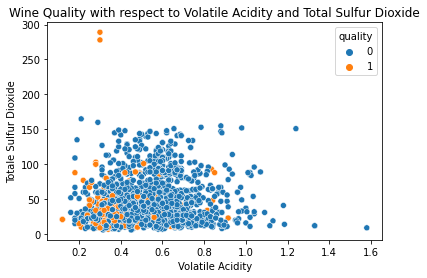

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# YOUR CODE HERE
# First copy the original data
rounded_quality_df = df.copy()

# Set the quality of the original data to the rounded quality that we found in question 1
rounded_quality_df['quality'] = wine['quality']

sns.scatterplot(data = rounded_quality_df, x ="volatile acidity", y="total sulfur dioxide", hue="quality")
plt.title("Wine Quality with respect to Volatile Acidity and Total Sulfur Dioxide")
plt.xlabel("Volatile Acidity")
plt.ylabel("Totale Sulfur Dioxide")

---
**Question 2b):** How might you try to classify the data based on just these two features and our scatter plot? E.g. Volatile acidity < (number1) and total sulfur dioxide < (number2) would be classified as good quality. Approximate the values of number1 and number2.

In [ ]:
number1 = 0.4 # YOUR CODE HERE
number2 = 50 # YOUR CODE HERE

---
**Question 2c):** Why could this visualization be misleading and make our approximations from the previous part wrong?

**Answer:**

This visualization could be misleading because of overplotting. A lot of the orange points seem like they could be covered by the blue points hence making our judgement of a good place to differentiate between the orange and blue points incorrect. 

---
**Question 2d):** Let's now try to visualize a simpler 1D case to see if we can more accurately find the decision boundary between good and bad quality wine. Create a scatter plot of volatile acidity against quality. 

Text(0, 0.5, 'Quality')

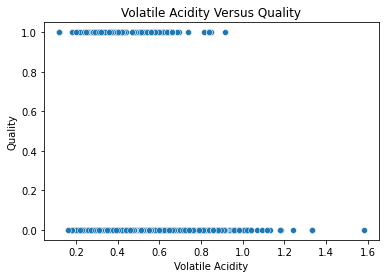

In [4]:
# YOUR CODE HERE
sns.scatterplot(data = rounded_quality_df, x ="volatile acidity", y="quality")
plt.title("Volatile Acidity Versus Quality")
plt.xlabel("Volatile Acidity")
plt.ylabel("Quality")

---
**Question 2e):** Add random uniform noise between [-0.1, 0.1] to the wine quality for each of our data points to better visualize the different data points. This technique is known as jittering. Refer to [np.random.uniform](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) documentation. 



Text(0, 0.5, 'Jittered Quality')

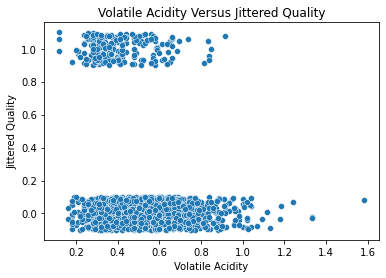

In [5]:
# YOUR CODE HERE
num_samples = rounded_quality_df.shape[0]
random_noise = np.random.uniform(-0.1,0.1,num_samples)
rounded_quality_df['jittered_quality'] = rounded_quality_df['quality'] + random_noise

sns.scatterplot(data = rounded_quality_df, x ="volatile acidity", y="jittered_quality")
plt.title("Volatile Acidity Versus Jittered Quality")
plt.xlabel("Volatile Acidity")
plt.ylabel("Jittered Quality")

---
**Question 2f):** Now looking at the above plot, do you think your estimate from question **2b)** would do an accurate job in differentiating between good and bad quality wine? In other words, do you think you could easily draw a vertical line to split the good quality and bad quality wine? This is the idea of a decision boundary.

**Answer:**

No, I do not think my estimate will do a good job in differentiating between good quality and bad quality wine. In the plot, I can see that there is a lot of overlap of qood quality and bad quality wine for similar intervals of volatile acidity.    

In the following parts of the project, we will formalize a process known as decision trees to better classify whether a wine is good quality or bad quality.

# Best Split Using the Gini Index
The Gini Index is a value ranging from $[0, 1]$ that represents the probability a feature will be incorrectly classified when randomly selected. In decision trees, features with a low gini index are highly desirable because it indicates that the classification is pure.

---
**Question 3a**: Implement the following function to compute the Gini Index. 

What is the Gini Index for the parent node? 

Recall that the Gini Index for a parent node can be calculated with the following formula: *$Gini(D) = 1 - \sum_{i=1}^{m} p_i^{2}$

*$p_i$ is the percentage of instances in $D$ when $i$ is the label

In [13]:
# YOUR CODE HERE
def compute_gini(X):
  good = np.where(X['quality'] == 1)[0].size
  bad = np.where(X['quality'] == 0)[0].size

  num_rows = X.shape[0]

  gini = 1 - (good / num_rows)**2 - (bad / num_rows)**2

  return gini

gini = compute_gini(wine)

print('The Gini Index for the parent node is:', gini)

The Gini Index for the parent node is: 0.234585327524512


---
**Question 3b)** The Gini Index for an attribute/split can be calculated with the following formula: 

$Gini_A(D) = \frac{|D_1|}{|D|}Gini(D_1) + \frac{|D_2|}{|D|}Gini(D_2)$

Implement the following helper functions to help us find the Gini Index for an attribute

In [16]:
# Implement a function to find all possible split values for an attribute
def find_splits_gini(X, column):
    # YOUR CODE HERE
    split_values = []

    X = X.sort_values(by = column)
    unique = list(set(X[column]))
    split_values = []

    # Set the split value to be the midpoint between consecutive values of the feature
    # YOUR CODE HERE
    for i in range(len(unique) - 1):
      split_values += [(unique[i] + unique[i + 1]) / 2]

    return split_values

# Next, implement a function to find the best split point for a feature and the 
# gini value of the best split
def best_split_point(X, column, splits):
    # YOUR CODE HERE
    best_split = 0
    min_gini = 100000
    num_rows = X.shape[0]

    for i in splits:
      below = X[X[column] < i]
      above = X[X[column] > i]
      num_above = len(above)
      num_below = len(below)

      gini_d1 = compute_gini(above)
      gini_d2 = compute_gini(below)

      gini = (num_above / num_rows) * gini_d1 + (num_below / num_rows) * gini_d2

      if gini < min_gini:
        min_gini = gini
        best_split = i

    return best_split, min_gini

---
**Question 3c**: Using the helper functions above, find the **best feature** that minimizes the Gini Index of its best split point. The best feature will be the root node of the decision tree. What is the **best split point** for this feature? What is the **gini index** of the best split point?

In [17]:
# YOUR CODE HERE
X = wine.drop('quality', axis=1)
min_gini = 10000

for col in X.columns: 
  splits = find_splits_gini(wine, col)

  split_point, gini = best_split_point(wine, col, splits)

  if gini < min_gini:
    best_feature = col
    best_split = split_point
    min_gini = gini

print('The best feature is:', best_feature)
print('The best split point for', best_feature, 'is:', best_split)
print('The gini index of the best split point for', best_feature, 'is:', min_gini)

The best feature is: alcohol
The best split point for alcohol is: 11.0
The gini index of the best split point for alcohol is: 0.18982598508811294


# Entropy (Information Gain)

We just saw that we found the best split by using the Gini index but that is not the only splitting method. In this section, we will explore a similar metric called entropy. The concept of gini and entropy in fact arose from similar motivations. Gini came from statistics and entropy from computer science/information theory. 

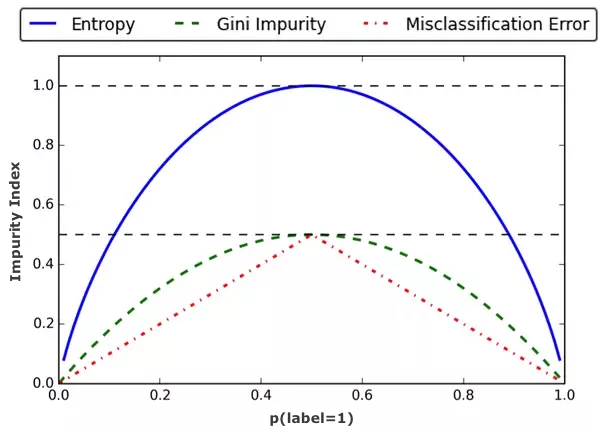


The graph above shows the visualization of these two metrics for binary classification as well as the misclassifation error for comparison. We notice that they are very similar. Let's explore entropy in more detail! 

---
**Question 4a)** Recall from physics what entropy represents. Entropy is a measure of the molecular disorder, or randomness, of a system. Let's try to model the "surprise" of some random variable $Y$ taking on the value $k$. This can be shown as,

"surprise" = $-log(P(Y = k))$

Find the limit of the "surprise" as $P(Y=k)$ approaches $0$.
Find the limit of the "surpise" as $P(Y=k)$ approaches $1$.
Explain why the above results make sense.

**Answer:**

"surprise" as $P(Y=k)$ approaches $0$: $infinity$

"surprise" as $P(Y=k)$ approaches $1$: $0$

These results make sense because as the probability goes to 1 that means we know 100% what will happen so the "surprise" is 0. Similary, as the probabiltiy goes to 0 that means we have no information hence the "surprise" is infinite.

---
**Question 4b)** Now lets try to formalize this idea of "surprise". The expectation of the surpise is denoted as the entropy $H$. 
$H(Y) = E[-logP(Y)] =- \sum_{k}P(Y=k)logP(Y=k)$

Now we can use this concept of entropy to decide on which split is the best by treating the probability of $k$ as the proportion of data points in a node with label $k$. We can now find the entropy of a node through this formula. 

Define the entropy $S$ of a node as:
$S = - \sum_{c}p_clog_2p_c$

**Find the entropy of the parent node.**

In [21]:
# YOUR CODE HERE
good = wine['quality'].value_counts()[1]
bad = wine['quality'].value_counts()[0]

num_rows = df.shape[0]

parent_entropy = -(good / num_rows) * math.log(good / num_rows,2) - (bad / num_rows) * math.log(bad / num_rows,2)

print('The entropy for the parent node is:', parent_entropy)

The entropy for the parent node is: 0.5728919822189028


---
**Question 4c)** We can now use use weighted entropy as a loss function to help us decide on the best split. 

$Loss$ = $\frac {N_1S(X) + N_2S(Y)}{N_1 + N_2}$


The above shows an example of a split given two nodes $X$ and $Y$ where $S(X)$ and $S(Y)$ represents the entropy of each and $N_1$ and $N_2$ represents the total number of samples respectively. 

Now, describe how you would use this loss function to find the best split for the wine data.

**ANSWER:** 

First all the data starts in the parent node.
Until every node is pure or unsplittable:
  - Pick the best feature and split value so that the loss of the resulting split minimizes the above loss function 
  -  Then split the data into the two nodes

---
**Question 4d)** Implement the following helper functions to help us find the best split.

In [23]:
# First implement a function to calculate the entropy given a split
def compute_entropy(split):
  # YOUR CODE HERE
  # Find the counts of each unique value of the split
  _, counts = np.unique(split, return_counts = True)
  # Find the proportion of each unique value
  p = counts / split.shape[0]
  entropy = -np.sum(p * np.log2(p))
  return entropy

# Next implement a function to find all possible split values, this will set the 
# the threshold of determining where the split goes
def find_splits_entropy(X, column):
    # Sort the unique values of the feature
    # YOUR CODE HERE
    X_unique = np.unique(X.iloc[:, column])

    # Initialize the split values
    # YOUR CODE HERE
    split_values = np.empty(X_unique.shape[0] - 1)

    # Set the split value to be the average value from the previous one
    # YOUR CODE HERE
    for i in range(1, X_unique.shape[0]):
        average = (X_unique[i - 1] + X_unique[i]) / 2
        split_values[i - 1] = average
    return split_values

# Next implement a function to find the weighted entropy of the splits, use the previous
# compute_entropy function to help with the implementation
def compute_splits_entropy(y, splits):
  # YOUR CODE HERE
    splits_entropy = 0
    for split in splits:
        splits_entropy += (split.shape[0] / y.shape[0]) * compute_entropy(split)
    return splits_entropy

# Next implement a function which will actually split the values based on the
# threshold value
def split(X, y, column, value):
  # YOUR CODE HERE
    left_y = y[X.iloc[:, column] <= value]
    right_y = y[X.iloc[:, column] > value]
    return left_y, right_y

---
**Question 4e)** Finally, using the helper functions and **question 4c)**, implement the find_best_split function which will find the best split by minimizing the weighted entropy. 

In [24]:
def find_best_split(X, y, max_features):
    subset = np.random.choice(X.shape[1], max_features, replace = False)
    # Set default best split attributes
    # YOUR CODE HERE
    best_col, best_val, best_gain = None, None, None

    for column in subset:
      # Find the split values
      # YOUR CODE HERE
        split_values = find_splits_entropy(X, column)
        for value in split_values:
            # Split on the value
            # YOUR CODE HERE
            splits = split(X, y, column, value)
            # Find the information gain of the splits, this is the parent entropy
            # subtracted by the splits entropy
            # YOUR CODE HERE
            gain = parent_entropy - compute_splits_entropy(y, splits)

            if best_gain is None or gain > best_gain:
                # Update the best split attributes
                best_col, best_val, best_gain = column, value, gain

    return best_col, best_val, best_gain

---
**Question 5f)** Using find_best_split, report the **best feature**, **split value**, and the **information gain** (parent entropy - splits entropy) using the wine data.  

In [25]:
# YOUR CODE HERE
X = wine.drop(columns='quality')
y = wine['quality']
best_col, best_val, best_gain = find_best_split(X, y, X.shape[1])

print('The best feature is:', df.columns[best_col])
print("The best split value is:", best_val)
print("The best gain is:", best_gain)

The best feature is: alcohol
The best split value is: 10.45
The best gain is: 0.09420078790299141


---
**Question 4g)** How does the best feature and split value using information gain compare to the best feature and split value using the Gini Index?

**Answer:**

The best feature is the same for information gain and the Gini Index (alcohol), but the best split value varies - it is 11 for the Gini Index and 10.45 for information gain.


# Building a Decision Tree Model

---
**Question 5a**: Split the data into testing and training sets and then apply standard scaling to the data

In [34]:
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_tree = wine.copy()
df_tree = wine.drop(columns='quality')

y = wine['quality']

X_train, X_test, Y_train, Y_test = train_test_split(df_tree, y, test_size = 0.2, random_state = 42)
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

---
**Question 5b**: Train a decision tree classifier with a depth of three. 

In [35]:
# YOUR CODE HERE
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3)

clf.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

---
**Question 5c**: What is the accuracy of the decision tree classifier on the training data? 

In [36]:
# YOUR CODE HERE 
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_train)

accuracy = accuracy_score(Y_train, y_pred)

print('The accuracy of the decision tree classifier on the training data is:', accuracy)

The accuracy of the decision tree classifier on the training data is: 0.9014855355746677


---
**Question 5d**: What is the accuracy of the decision tree classifier on the testing data? 

In [37]:
# YOUR CODE HERE 
y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)

print('The accuracy of the decision tree classifier on the testing data is:', accuracy)

The accuracy of the decision tree classifier on the testing data is: 0.85625


---
**Question 5e**: Visualize your decision tree with graphviz. Comment on your observations.



In [38]:
!sudo apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


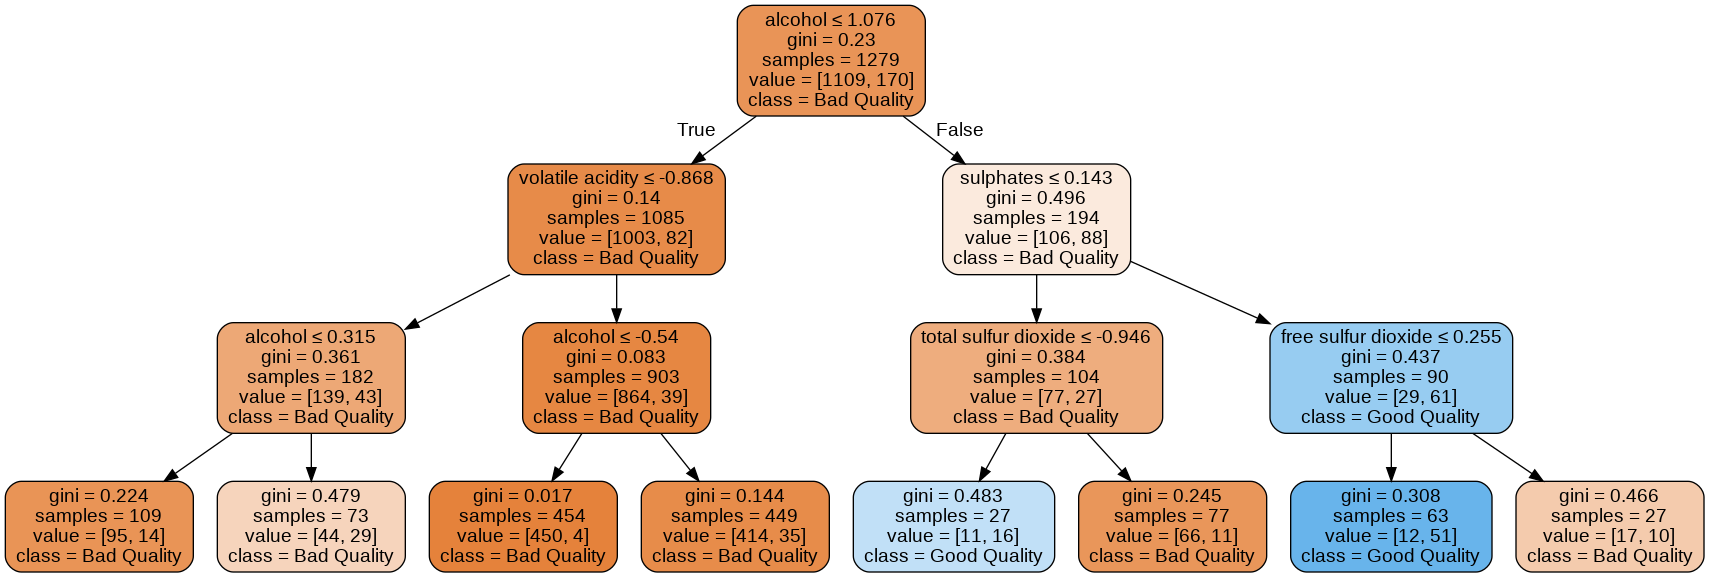

In [39]:
from IPython.display import Image  
import pydotplus 
import pydot
from sklearn.externals.six import StringIO
from sklearn import tree

out = StringIO() 
tree.export_graphviz(clf, out_file=out,
                      feature_names=list(df_tree.columns),  
                          class_names=['Bad Quality', 'Good Quality'],  
                          filled=True, rounded=True,  
                          special_characters=True)
graph = pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

**Observations:**

Since there is a significantly higher amount of bad quality wines over good quality wines, most of the decision tree nodes have bad quality wines as the majority class. However, we can observe that good quality wines are the majority class only when the standardized value of alcohol is greater than 1.071. From there, the most distinctive feature for good quality wines is having sulphates greater than 0.163 and free sulfur dioxide less than or equal to 0.258. We can also observe that the gini is higher for leaf nodes that have similar amounts of good quality/bad quality wines - the leaf node with the lowest gini has 450 bad quality wines and only 4 good quality wines, while the leaf node with the highest gini has 11 bad quality wines and 16 good quality wines.